In [57]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline  
import glob
import random
from skimage.color import rgb2gray
from skimage.transform import rotate

In [241]:
'''
Plot an array of images as a grid of images

params:
-------
figsize  tuble  width and height of each figure.
rows     int    count of grid rows.
cols     int    count of grid cols.
imgs     list   list of images, each image is stored as a numpy array. 
'''
def draw_grid(figsize=(10,10), rows=5,cols=5,imgs=[]):
    fig = plt.figure(figsize=figsize)

    for i in range(len(imgs)):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
    plt.show()
  
'''
Read all images placed at the given directory.

params:
-------
dir_path  string  path of directory that contain images to be read.

return:
------
imgs      list    list of all images read from the directory. each image is read as a numpy array.

'''
def read_imgs(dir_path='space_testing'):
    paths = glob.glob(dir_path+'/**')
    imgs = []
    for img_path in paths:
        imgs.append(cv2.imread(img_path))
    return imgs

In [251]:
'''
Extract The start and end of each sequence of successive true values in the array.

params:
------
arr          np.array  boolean array containing false and true values

return:
-------
lines_start  np.array  array containing the start index of each sequence of true values.
lines_end    np.array  array containing the end index of each sequence of true values.

example:
-------

arr = np.array([True True False True True True False True False])
lines_start, lines_end = extract_successive_trues(arr)

>> lines_start
array([0 3 7])

>> lines_end
array([2 6 8])

'''
def extract_successive_trues(arr):
    processing_line = False
    lines_start = []
    lines_end = []

    for i in range(len(horiz_proj)):
        if(processing_line == True):
            if(horiz_proj[i] == False):
                lines_end.append(i)
                processing_line = False
        else:
            if(horiz_proj[i] == True):
                processing_line = True
                lines_start.append(i)
                
    # if the last element in arr was true
    if (len(lines_end) == len(lines_start) - 1):
        # Set the end of the last line as the last index of the array
        lines_end.append(len(horiz_proj))
        
    return lines_start, lines_end

In [252]:
'''
Extract lines from a handwritten image.

params:
-------
img                   np.arrray()   Image to extract lines from.
margin_top            float         How many pixels above the extracted line to consider.
margin_bottom         float         How many pixels below the extracted line to consider.
avg_thickness_perc    float         The percentage of the average thickness below which to discard a line.
verbose               boolean       If true show a visualization of the lines extracted. By default: False.

returns:
-------
lines                 list          List of images, each image holds a line extracted from the original image. Each image is an np.array.
'''
def extract_lines(img, margin_top=30, margin_bottom=15, avg_thickness_perc = 0.5, verbose=False):
    
    # Sum across the horizontal axis i.e across the text lines
    horiz_proj = np.sum(img, axis=1)
    
    # Calculating the threshold between having text (a line) or having white spacing between lines
    avg = np.average(horiz_proj)
    margin = (np.max(horiz_proj)-avg)/3
    thres = avg + margin
    
    if (verbose):
        # Rotate image by 90 degrees
        img_90 = rotate(img, 90, resize=True)
        plt.imshow(img_90, cmap='gray')

        # Plot the lines' summation values
        plt.plot(range(0,len(horiz_proj)),horiz_proj) 

        plt.axhline(y=thres, color='r', linestyle='-')
        plt.show()
    
    # Extract Lines start index and end index
    lines_start, lines_end = extract_successive_trues(horiz_proj < thres)
    
    lines = []
    lines_thickness = []

    # Discard noisy lines - lines with thickness smaller than 10 pixels
    for i in range(len(lines_start)):
        line_thickness = lines_end[i] - lines_start[i]
        if (line_thickness > 10):
            lines_thickness.append(line_thickness)  

    # Estimate the average thickness of filtered lines (for Lines > 10 pixels)
    lines_thickness = np.array([lines_thickness])
    avg_thickness = np.average(lines_thickness)
    print('lines_thickness array: ', lines_thickness)
    print('avg_thickness array: ', avg_thickness)
    print('discard lines thiner than: ', avg_thickness*avg_thickness_perc)

    lines_thickness = []
    # Extract the lines from the image
    for i in range(len(lines_start)):
        # Add margines to the lines starting and ending indices
        line_top = lines_start[i] - margin_top
        line_bottom = lines_end[i] + margin_bottom

        line_thickness = lines_end[i] - lines_start[i]
        # Discard noisy lines - lines with thickness smaller than 0.5 of the average thicknesses (default)
        if (line_thickness > avg_thickness_perc*avg_thickness):
            lines_thickness.append(line_thickness)
            lines.append(img[line_top:line_bottom, :])
            if (verbose):
                plt.imshow(img[line_top:line_bottom, :])
                plt.show()

    print('lines_thickness array: ', lines_thickness)
    return lines

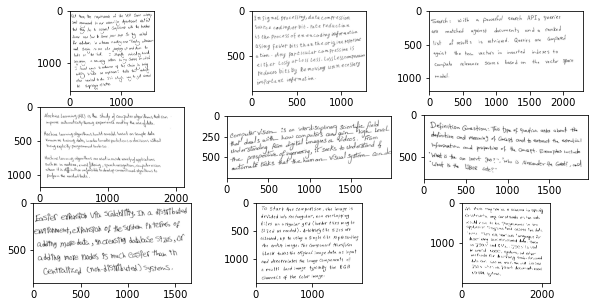

In [248]:
# Read the test images
imgs = read_imgs('space_testing')

# Preview 9 samples
draw_grid(figsize=(10,5), rows=3, cols=3, imgs=imgs[:9])

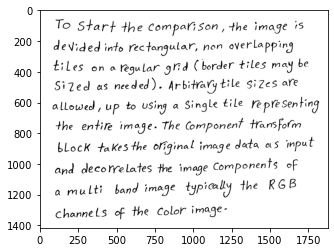

In [249]:
# Choosing a random image
rand_indx = random.randint(0,len(imgs))
img = imgs[rand_indx]
plt.imshow(img)
plt.show()
# Trivial Thresholding the image to only 0 and 255
img = rgb2gray(img)
img_black_loc = img <= 0.5
img_white_loc = img > 0.5
img[img_black_loc] = 0
img[img_white_loc] = 1

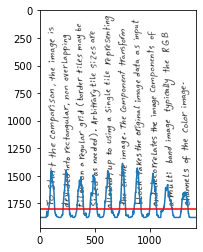

lines_thickness array:  [[55 57 62 64 62 55 64 63 80 60]]
avg_thickness array:  62.2
discard lines thiner than:  31.1


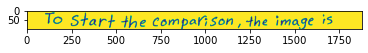

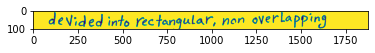

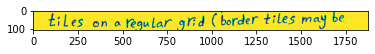

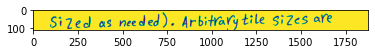

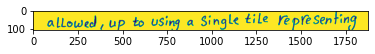

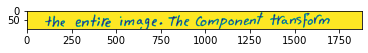

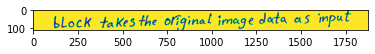

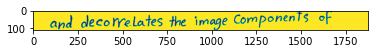

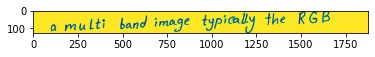

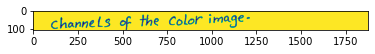

lines_thickness array:  [55, 57, 62, 64, 62, 55, 64, 63, 80, 60]


In [253]:
lines = extract_lines(img=img, verbose=True)